# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science


## Lab 4: Multiple and Polynomial Regression (September 26, 2019 version) 

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors:** Pavlos Protopapas, Kevin Rader, and Chris Tanner<br/>
**Lab Instructor:** Chris Tanner and Eleni Kaxiras<br/>
**Authors:** Rahul Dave, David Sondak, Will Claybaugh, Pavlos Protopapas, Chris Tanner

---

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Table of Contents

<ol start="0">
<li> Learning Goals / Tip of the Week / Terminology </li>
<li> Training/Validation/Testing Splits (slides + interactive warm-up)</li>
<li> Polynomial Regression, and Revisiting the Cab Data</li>
<li> Multiple regression and exploring the Football data </li>
<li> A nice trick for forward-backwards </li>
    <li> Cross-validation</li>
</ol>

## Learning Goals
After this lab, you should be able to
- Explain the difference between train/validation/test data and WHY we have each.
- Implement cross-validation on a dataset
- Implement arbitrary multiple regression models in both SK-learn and Statsmodels.
- Interpret the coefficent estimates produced by each model, including transformed and dummy variables

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline

## Extra Tip of the Week

Within your terminal (aka console aka command prompt), most shell environments support useful shortcuts:

<ul>
  <li>press the [up arrow] to navigate through your most recent commands</li>
  <li>press [CTRL + A] to go to the beginning of the line</li>
  <li>press [CTRL + E] to go to the end of the line</li>
  <li>press [CTRL + K] to clear the line</li>
  <li>type `history` to see the last commands you've run</li>
</ul>  


## Terminology

Say we have input features $X$, which via some function $f()$, approximates outputs $Y$. That is, $Y = f(X) + \epsilon$ (where $\epsilon$ represents our unmeasurable variation (i.e., irreducible error).

- **Inference**: estimates the function $f$, but the goal isn't to make predictions for $Y$; rather, it is more concerned with understanding the relationship between $X$ and $Y$.
- **Prediction**: estimates the function $f$ with the goal of making accurate $Y$ predictions for some unseen $X$.


We have recently used two highly popular, useful libraries, `statsmodels` and `sklearn`.

`statsmodels` is mostly focused on the _inference_ task. It aims to make good estimates for $f()$ (via solving for our $\beta$'s), and it provides expansive details about its certainty. It provides lots of tools to discuss confidence, but isn't great at dealing with test sets.

`sklearn` is mostly focused on the _prediction_ task. It aims to make a well-fit line to our input data $X$, so as to make good $Y$ predictions for some unseen inputs $X$. It provides a shallower analysis of our variables. In other words, `sklearn` is great at test sets and validations, but it can't really discuss uncertainty in the parameters or predictions.


- **R-squared**: An interpretable summary of how well the model did. 1 is perfect, 0 is a trivial baseline model based on the mean $y$ value, and negative is worse than the trivial model.
- **F-statistic**: A value testing whether we're likely to see these results (or even stronger ones) if none of the predictors actually mattered.
- **Prob (F-statistic)**: The probability that we'd see these results (or even stronger ones) if none of the predictors actually mattered. If this probability is small then either A) some combination of predictors actually matters or B) something rather unlikely has happened
- **coef**: The estimate of each beta. This has several sub-components:
  - **std err**: The amount we'd expect this value to wiggle if we re-did the data collection and re-ran our model. More data tends to make this wiggle smaller, but sometimes the collected data just isn't enough to pin down a particular value.
  - **t and P>|t|**: similar to the F-statistic, these measure the probability of seeing coefficients this big (or even bigger) if the given variable didn't actually matter. Small probability doesn't necessarily mean the value matters
  - **\[0.025 0.975\]**: Endpoints of the 95% confidence interval. This is a interval drawn in a clever way and which gives an idea of where the true beta value might plausibly live. (If you want to understand why "there's a 95% chance the true beta is in the interval" is _wrong_, start a chat with Will : )
  

## Part 2: Polynomial Regression, and Revisiting the Cab Data

Polynomial regression uses a **linear model** to estimate a **non-linear function** (i.e., a function with polynomial terms). For example:

$y = \beta_0 + \beta_1x_i + \beta_1x_i^{2}$

It is a linear model because we are still solving a linear equation (the _linear_ aspect refers to the beta coefficients).

In [4]:
# read in the data, break into train and test
cab_df = pd.read_csv("data/dataset_1.txt")
train_data, test_data = train_test_split(cab_df, test_size=.2, random_state=42)
cab_df.head()

,TimeMin,PickupCount
0,860.0,33.0
1,17.0,75.0
2,486.0,13.0
3,300.0,5.0
4,385.0,10.0


In [5]:
cab_df.shape

(1250, 2)

In [6]:
# do some data cleaning
X_train = train_data['TimeMin'].values.reshape(-1,1)/60 # transforms it to being hour-based
y_train = train_data['PickupCount'].values

X_test = test_data['TimeMin'].values.reshape(-1,1)/60 # hour-based
y_test = test_data['PickupCount'].values

def plot_cabs(cur_model, poly_transformer=None):
    
    # build the x values for the prediction line
    x_vals = np.arange(0,24,.1).reshape(-1,1)
    
    # optionally use the passed-in transformer
    if poly_transformer != None:
        dm = poly_transformer.fit_transform(x_vals)
    else:
        dm = x_vals
        
    # make the prediction at each x value
    prediction = cur_model.predict(dm)
    
    # plot the prediction line, and the test data
    plt.plot(x_vals,prediction, color='k', label="Prediction")
    plt.scatter(X_test, y_test, label="Test Data")

    # label your plots
    plt.ylabel("Number of Taxi Pickups")
    plt.xlabel("Time of Day (Hours Past Midnight)")
    plt.legend()
    plt.show()

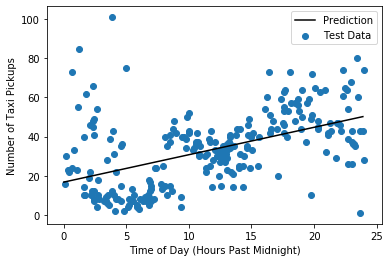

In [7]:
from sklearn.linear_model import LinearRegression
fitted_cab_model0 = LinearRegression().fit(X_train, y_train)
plot_cabs(fitted_cab_model0)

In [8]:
fitted_cab_model0.score(X_test, y_test)

0.240661535615741

<div class="exercise"><b>Exercise</b></div>

**Questions**:
1. The above code uses `sklearn`. As more practice, and to help you stay versed in both libraries, perform the same task (fit a linear regression line) using `statsmodels` and report the $r^2$ score. Is it the same value as what sklearn reports, and is this the expected behavior?

In [14]:
#### EXERCISE: write code here (feel free to work with a partner)
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()
f_test = model.predict(results.params, exog=sm.add_constant(X_test))
r2_test = r2_score(y_test, f_test)  # Always truth, then predicted
print(r2_test)

0.240661535615741


We can see that there's still a lot of variation in cab pickups that's not being captured by a linear fit. Further, the linear fit is predicting massively more pickups at 11:59pm than at 12:00am. This is a bad property, and it's the conseqeuence of having a straight line with a non-zero slope. However, we can add columns to our data for $TimeMin^2$ and $TimeMin^3$ and so on, allowing a curvy polynomial line to hopefully fit the data better.

We'll be using ``sklearn``'s `PolynomialFeatures()` function to take some of the tedium out of building the expanded input data. In fact, if all we want is a formula like $y \approx \beta_0 + \beta_1 x + \beta_2 x^2 + ...$, it will directly return a new copy of the data in this format!

In [15]:
transformer_3 = PolynomialFeatures(3, include_bias=False)
expanded_train = transformer_3.fit_transform(X_train) # TRANSFORMS it to polynomial features
pd.DataFrame(expanded_train).describe() # notice that the columns now contain x, x^2, x^3 values

,0,1,2
count,1000.000000,1000.000000,1000.000000
mean,11.717217,182.833724,3234.000239
std,6.751751,167.225711,3801.801966
min,0.066667,0.004444,0.000296
25%,6.100000,37.210833,226.996222
50%,11.375000,129.390694,1471.820729
75%,17.437500,304.066458,5302.160684
max,23.966667,574.401111,13766.479963


A few notes on `PolynomialFeatures`:

- The interface is a bit strange. `PolynomialFeatures` is a _'transformer'_ in sklearn. We'll be using several transformers that learn a transformation on the training data, and then we will apply those transformations on future data. With PolynomialFeatures, the `.fit()` is pretty trivial, and we often fit and transform in one command, as seen above with ``.fit_transform()`.
- You rarely want to `include_bias` (a column of all 1's), since _**sklearn**_ will add it automatically. Remember, when using _**statsmodels,**_ you can just `.add_constant()` right before you fit the data.
- If you want polynomial features for a several different variables (i.e., multinomial regression), you should call `.fit_transform()` separately on each column and append all the results to a copy of the data (unless you also want interaction terms between the newly-created features). See `np.concatenate()` for joining arrays.

fitting expanded_train: [[6.73333333e+00 4.53377778e+01 3.05274370e+02]
 [2.18333333e+00 4.76694444e+00 1.04078287e+01]
 [1.41666667e+00 2.00694444e+00 2.84317130e+00]
 ...
 [1.96666667e+01 3.86777778e+02 7.60662963e+03]
 [1.17333333e+01 1.37671111e+02 1.61534104e+03]
 [1.42000000e+01 2.01640000e+02 2.86328800e+03]]


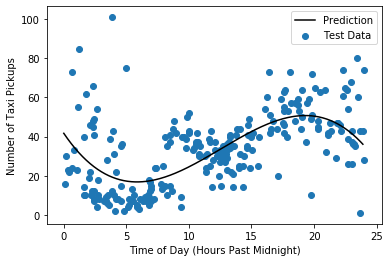

In [16]:
fitted_cab_model3 = LinearRegression().fit(expanded_train, y_train)
print("fitting expanded_train:", expanded_train)
plot_cabs(fitted_cab_model3, transformer_3)

<div class="exercise"><b>Exercise</b></div>

**Questions**:
1. Calculate the polynomial model's $R^2$ performance on the test set. 
2. Does the polynomial model improve on the purely linear model?
3. Make a residual plot for the polynomial model. What does this plot tell us about the model?

In [19]:
# ANSWER 1
expanded_test = transformer_3.fit_transform(X_test)
print("Test R-squared:", fitted_cab_model3.score(expanded_test, y_test))
# NOTE 1: unlike statsmodels' r2_score() function, sklearn has a .score() function
# NOTE 2: fit_transform() is a nifty function that fits, then transforms

Test R-squared: 0.3341251257077831


### ANSWER 2: does it?
Duh

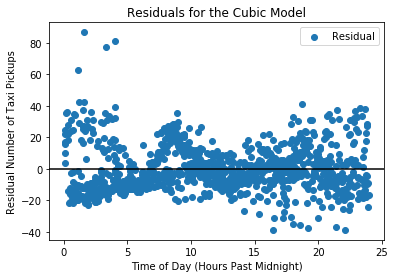

In [17]:
# ANSWER 3 (class discussion about the residuals)
x_matrix = transformer_3.fit_transform(X_train)

prediction = fitted_cab_model3.predict(x_matrix)
residual = y_train - prediction
plt.scatter(X_train, residual, label="Residual")
plt.axhline(0, color='k')

plt.title("Residuals for the Cubic Model")
plt.ylabel("Residual Number of Taxi Pickups")
plt.xlabel("Time of Day (Hours Past Midnight)")
plt.legend()

#### Other features
Polynomial features are not the only constucted features that help fit the data. Because these data have a 24 hour cycle, we may want to build features that follow such a cycle. For example, $sin(24\frac{x}{2\pi})$, $sin(12\frac{x}{2\pi})$, $sin(8\frac{x}{2\pi})$. Other feature transformations are appropriate to other types of data. For instance certain feature transformations have been developed for geographical data.

### Scaling Features
When using polynomials, we are explicitly trying to use the higher-order values for a given feature. However, sometimes these polynomial features can take on values that are drastically large, making it difficult for the system to learn an appropriate bias weight due to its large values and potentially large variance. To counter this, sometimes one may be interested in scaling the values for a given feature.

For our ongoing taxi-pickup example, using polynomial features improved our model. If we wished to scale the features, we could use `sklearn`'s StandardScaler() function:

In [20]:
# SCALES THE EXPANDED/POLY TRANSFORMED DATA
# we don't need to convert to a pandas dataframe, but it can be useful for scaling select columns
train_copy = pd.DataFrame(expanded_train.copy())
test_copy = pd.DataFrame(expanded_test.copy())

# Fit the scaler on the training data
scaler = StandardScaler().fit(train_copy)

# Scale both the test and training data. 
train_scaled = scaler.transform(expanded_train)
test_scaled = scaler.transform(expanded_test)

# we could optionally run a new regression model on this scaled data
fitted_scaled_cab = LinearRegression().fit(train_scaled, y_train)
fitted_scaled_cab.score(test_scaled, y_test)

0.33412512570778274

## Why Fit then Transform?
Example in `StandardScaler`, it first finds the `miu` and `sigma`. That is the 'fitting'.  
Then it applies `(x - miu)/sigma`, which is the transform.

<hr style="height:3px">

## Part 3: Multiple regression and exploring the Football (aka soccer) data
Let's move on to a different dataset! The data imported below were scraped by [Shubham Maurya](https://www.kaggle.com/mauryashubham/linear-regression-to-predict-market-value/data) and record various facts about players in the English Premier League. Our goal will be to fit models that predict the players' market value (what the player could earn when hired by a new team), as estimated by https://www.transfermarkt.us.

`name`: Name of the player  
`club`: Club of the player  
`age` : Age of the player  
`position` : The usual position on the pitch  
`position_cat` :  1 for attackers, 2 for midfielders, 3 for defenders, 4 for goalkeepers  
`market_value` : As on transfermrkt.com on July 20th, 2017  
`page_views` : Average daily Wikipedia page views from September 1, 2016 to May 1, 2017  
`fpl_value` : Value in Fantasy Premier League as on July 20th, 2017  
`fpl_sel` : % of FPL players who have selected that player in their team  
`fpl_points` : FPL points accumulated over the previous season  
`region`: 1 for England, 2 for EU, 3 for Americas, 4 for Rest of World  
`nationality`: Player's nationality  
`new_foreign`: Whether a new signing from a different league, for 2017/18 (till 20th July)  
`age_cat`: a categorical version of the Age feature  
`club_id`: a numerical version of the Club feature  
`big_club`: Whether one of the Top 6 clubs  
`new_signing`: Whether a new signing for 2017/18 (till 20th July)  

As always, we first import, verify, split, and explore the data.

## Part 3.1: Import and verification and grouping

In [21]:
league_df = pd.read_csv("data/league_data.txt")
print(league_df.dtypes)

# QUESTION: what would you guess is the mean age? mean salary?
#league_df.head()

name             object
club             object
age               int64
position         object
position_cat      int64
market_value    float64
page_views        int64
fpl_value       float64
fpl_sel          object
fpl_points        int64
region          float64
nationality      object
new_foreign       int64
age_cat           int64
club_id           int64
big_club          int64
new_signing       int64
dtype: object


In [22]:
league_df.shape

(461, 17)

In [18]:
#league_df.describe()

### (Stratified) train/test split
We want to make sure that the training and test data have appropriate representation of each region; it would be bad for the training data to entirely miss a region. This is especially important because some regions are rather rare.

<div class="exercise"><b>Exercise</b></div>

**Questions**:
1. Use the `train_test_split()` function, while (a) ensuring the test size is 20% of the data, and; (2) using 'stratify' argument to split the data (look up documentation online), keeping equal representation of each region. This doesn't work by default, correct? What is the issue?
2. Deal with the issue you encountered above. Hint: you may find numpy's `.isnan()` and panda's `.dropna()` functions useful!
3. How did you deal with the error generated by `train_test_split`? How did you justify your action? 

*your answer here*:


In [40]:
# EXERCISE: feel free to work with a partner
print(len(league_df), len(league_df.dropna()))
train_data, test_data = train_test_split(league_df.dropna(), test_size=.2, stratify=league_df.region.dropna())

461 460


In [41]:
train_data.shape, test_data.shape

((368, 17), (92, 17))

Now that we won't be peeking at the test set, let's explore and look for patterns! We'll introduce a number of useful pandas and numpy functions along the way. 

### Groupby
Pandas' `.groupby()` function is a wonderful tool for data analysis. It allows us to analyze each of several subgroups.

Many times, `.groupby()` is combined with `.agg()` to get a summary statistic for each subgroup. For instance: What is the average market value, median page views, and maximum fpl for each player position?

In [42]:
train_data.groupby('position').agg({
    'market_value': np.mean,
    'page_views': np.median,
    'fpl_points': np.max
})

,market_value,page_views,fpl_points
position,,,
AM,26.950000,1130.0,218
CB,8.585507,338.0,178
CF,14.293478,983.0,224
CM,11.213542,420.5,225
DM,11.732143,513.5,131
GK,8.578125,419.0,143
LB,8.362069,380.0,177
LM,4.535714,347.0,99
LW,13.466071,574.5,264


In [43]:
train_data.position.unique()

array(['RW', 'GK', 'RB', 'CB', 'LB', 'CM', 'DM', 'CF', 'AM', 'LW', 'RM',
       'LM', 'SS'], dtype=object)

In [44]:
train_data.groupby(['big_club', 'position']).agg({
    'market_value': np.mean,
    'page_views': np.mean,
    'fpl_points': np.mean
})

market_value   page_views  fpl_points
big_club position                                       
0        AM           14.906250   603.750000   79.125000
         CB            4.914583   321.270833   42.041667
         CF            8.078125   915.343750   57.562500
         CM            5.536765   331.470588   38.323529
         DM            7.676471   446.176471   45.882353
         GK            5.068182   390.818182   57.363636
         LB            5.025000   254.050000   39.350000
         LM            4.458333   364.833333   56.666667
         LW            7.583333   497.777778   54.555556
         RB            4.837500   266.300000   56.000000
         RM            4.333333   280.333333    1.666667
         RW            8.413043   613.695652   53.826087
         SS            6.916667  1861.666667   51.500000
1        AM           40.714286  2322.428571  160.857143
         CB           16.976190   842.476190   65.380952
         CF           28.500000  2494.357143  100.714286
         CM           25.000000  2122.571429   82.214286
         DM           18.000000  1008.000000   57.454545
         GK           16.300000   879.700000   71.400000
         LB           15.777778   867.222222   68.888889
         LM            5.000000   936.000000   26.000000
         LW           24.055000  1995.100000  100.200000
         RB           14.937500   886.625000   87.375000
         RM           18.000000  2537.000000  105.000000
         RW           27.000000  1420.500000   78.000000
         SS           38.000000  2196.000000  180.000000

<div class="exercise"><b>Exercise</b></div>

**Question**:
1. Notice that the `.groupby()` function above takes a list of two column names. Does the order matter? What happens if we switch the two so that 'position' is listed before 'big_club'?

In [45]:
# EXERCISE: feel free to work with a partner
train_data.groupby(['position', 'big_club']).agg({
    'market_value': np.mean,
    'page_views': np.mean,
    'fpl_points': np.mean
})

market_value   page_views  fpl_points
position big_club                                       
AM       0            14.906250   603.750000   79.125000
         1            40.714286  2322.428571  160.857143
CB       0             4.914583   321.270833   42.041667
         1            16.976190   842.476190   65.380952
CF       0             8.078125   915.343750   57.562500
         1            28.500000  2494.357143  100.714286
CM       0             5.536765   331.470588   38.323529
         1            25.000000  2122.571429   82.214286
DM       0             7.676471   446.176471   45.882353
         1            18.000000  1008.000000   57.454545
GK       0             5.068182   390.818182   57.363636
         1            16.300000   879.700000   71.400000
LB       0             5.025000   254.050000   39.350000
         1            15.777778   867.222222   68.888889
LM       0             4.458333   364.833333   56.666667
         1             5.000000   936.000000   26.000000
LW       0             7.583333   497.777778   54.555556
         1            24.055000  1995.100000  100.200000
RB       0             4.837500   266.300000   56.000000
         1            14.937500   886.625000   87.375000
RM       0             4.333333   280.333333    1.666667
         1            18.000000  2537.000000  105.000000
RW       0             8.413043   613.695652   53.826087
         1            27.000000  1420.500000   78.000000
SS       0             6.916667  1861.666667   51.500000
         1            38.000000  2196.000000  180.000000

<hr style="height:3px">

## Part 3.2: Linear regression on the football data
This section of the lab focuses on fitting a model to the football (soccer) data and interpreting the model results. The model we'll use is

$$\text{market_value} \approx \beta_0 + \beta_1\text{fpl_points} + \beta_2\text{age} + \beta_3\text{age}^2 + \beta_4log_2\left(\text{page_views}\right) + \beta_5\text{new_signing} +\beta_6\text{big_club} + \beta_7\text{position_cat}$$

We're including a 2nd degree polynomial in age because we expect pay to increase as a player gains experience, but then decrease as they continue aging. We're taking the log of page views because they have such a large, skewed range and the transformed variable will have fewer outliers that could bias the line. We choose the base of the log to be 2 just to make interpretation cleaner.

<div class="exercise"><b>Exercise</b></div>

**Questions**:
1. Build the data and fit this model to it. How good is the overall model?
2. Interpret the regression model. What is the meaning of the coefficient for:
    - age and age$^2$
    - $log_2($page_views$)$
    - big_club
3. What should a player do in order to improve their market value? How many page views should a player go get to increase their market value by 10?

In [53]:
# Q1: we'll do most of it for you ...
y_train = train_data['market_value']
y_test = test_data['market_value']
def build_football_data(df):
    x_matrix = df[['fpl_points','age','new_signing','big_club','position_cat']].copy()
    x_matrix['log_views'] = np.log2(df['page_views'])
    
    # WRITE CODE FOR CREATING THE AGE SQUARED COLUMN
    ####
    x_matrix['age_squared'] = df['age']**2 
    
    # OPTIONALLY WRITE CODE to adjust the ordering of the columns, just so that it corresponds with the equation above
    ####
    index = ['fpl_points', 'age', 'age_squared', 'log_views', 'new_signing', 'big_club', 'position_cat']
    x_matrix.reindex(index=index)
    
    # add a constant
    x_matrix = sm.add_constant(x_matrix)
    
    return x_matrix

# use build_football_data() to transform both the train_data and test_data
train_transformed = build_football_data(train_data)
test_transformed = build_football_data(test_data)

fitted_model_1 = OLS(endog= y_train, exog=train_transformed, hasconst=True).fit()
fitted_model_1.summary()

# WRITE CODE TO RUN r2_score(), then answer the above question about the overall goodness of the model
f_test = fitted_model_1.predict(test_transformed)
print(r2_score(y_test, f_test))

0.6347401222016458


/home/dev15/anaconda3/envs/pandai/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Text(0, 0.5, 'Contribution to Predicted Market Value')

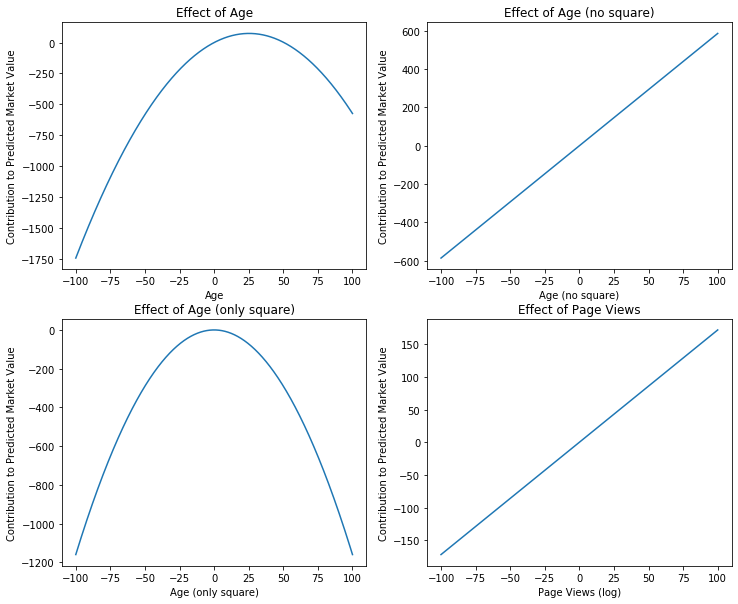

In [67]:
# Q2: let's use the age coefficients to show the effect of age has on one's market value;
# we can get the age and age^2 coefficients via:
agecoef = fitted_model_1.params.age
age2coef = fitted_model_1.params.age_squared

# let's set our x-axis (corresponding to age) to be a wide range from -100 to 100, 
# just to see a grand picture of the function
x_vals = np.linspace(-100,100,1000)
y_vals = agecoef*x_vals +age2coef*x_vals**2

# WRITE CODE TO PLOT x_vals vs y_vals
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
axes[0][0].plot(x_vals, y_vals)
axes[0][0].set_title("Effect of Age")
axes[0][0].set_xlabel("Age")
axes[0][0].set_ylabel("Contribution to Predicted Market Value")


# Q2A: WHAT HAPPENS IF WE USED ONLY AGE (not AGE^2) in our model (what's the r2?); make the same plot of age vs market value
yA_vals = agecoef*x_vals
axes[0][1].plot(x_vals, yA_vals)
axes[0][1].set_title("Effect of Age (no square)")
axes[0][1].set_xlabel("Age (no square)")
axes[0][1].set_ylabel("Contribution to Predicted Market Value")


# Q2B: WHAT HAPPENS IF WE USED ONLY AGE^2 (not age) in our model (what's the r2?); make the same plot of age^2 vs market value
yB_vals = age2coef*x_vals**2
axes[1][0].plot(x_vals, yB_vals)
axes[1][0].set_title("Effect of Age (only square)")
axes[1][0].set_xlabel("Age (only square)")
axes[1][0].set_ylabel("Contribution to Predicted Market Value")

# Q2C: PLOT page views vs market value
viewcoeff = fitted_model_1.params.log_views
y_page = viewcoeff*x_vals
axes[1][1].plot(x_vals, y_page)
axes[1][1].set_title("Effect of Page Views")
axes[1][1].set_xlabel("Page Views (log)")
axes[1][1].set_ylabel("Contribution to Predicted Market Value")

# EXERCISE: WRITE CODE HERE

<hr style='height:3px'>

### Part 3.3: Turning Categorical Variables into multiple binary variables
Of course, we have an error in how we've included player position. Even though the variable is numeric (1,2,3,4) and the model runs without issue, the value we're getting back is garbage. The interpretation, such as it is, is that there is an equal effect of moving from position category 1 to 2, from 2 to 3, and from 3 to 4, and that this effect is probably between -0.5 to -1 (depending on your run).

In reality, we don't expect moving from one position category to another to be equivalent, nor for a move from category 1 to category 3 to be twice as important as a move from category 1 to category 2. We need to introduce better features to model this variable.

We'll use `pd.get_dummies` to do the work for us.

In [68]:
# one-hot encoding
train_design_recoded = pd.get_dummies(train_transformed, columns=['position_cat'], drop_first=True)
test_design_recoded = pd.get_dummies(test_transformed, columns=['position_cat'], drop_first=True)

train_design_recoded.head()

,const,fpl_points,age,new_signing,big_club,log_views,age_squared,position_cat_2,position_cat_3,position_cat_4
363,1.0,34,24,0,0,8.771489,576,0,0,0
353,1.0,116,32,0,0,8.154818,1024,0,0,1
140,1.0,102,23,0,0,9.489848,529,0,0,1
157,1.0,1,20,0,0,5.727920,400,0,1,0
49,1.0,4,24,0,0,8.721099,576,0,1,0


We've removed the original `position_cat` column and created three new ones.

#### Why only three new columns?
Why does pandas give us the option to drop the first category? 

<div class="exercise"><b>Exercise</b></div>

To save memory

**Questions**:
1. If we're fitting a model without a constant, should we have three dummy columns or four dummy columns?
2. Fit a model on the new, recoded data, then interpret the coefficient of `position_cat_2`.

If our model does not have a constant, we must include all four dummy variable columns. If we drop one, we're not modeling any effect of being in that category, and effectively assuming the dropped category's effect is 0.

In [70]:
# use build_football_data() to transform both the train_data and test_data
fitted_model_2 = OLS(endog= y_train, exog=train_design_recoded, hasconst=True).fit()
fitted_model_2.summary()

# WRITE CODE TO RUN r2_score(), then answer the above question about the overall goodness of the model
f_test = fitted_model_2.predict(test_design_recoded)
print(r2_score(y_test, f_test))
print(fitted_model_2.params.position_cat_2)

0.6269661329406606
-0.329574589170063


**Answers**:
The coefficient of `position_cat_2` is negative, meaning players who belong in this position are predicted to have 33% lower market value than if they were not.

## Part 4: A nice trick for forward-backwards

XOR (operator ^) is a logical operation that only returns true when input differ. We can use it to implement forward-or-backwards selection when we want to keep track of whet predictors are "left" from a given list of predictors.

The set analog is "symmetric difference". From the python docs:

`s.symmetric_difference(t)	s ^ t	new set with elements in either s or t but not both`


In [71]:
set() ^ set([1,2,3])

{1, 2, 3}

In [72]:
set([1]) ^ set([1,2,3])

{2, 3}

In [73]:
set([1, 2]) ^ set([1,2,3])

{3}

<div class="exercise"><b>Exercise</b></div>

Outline a step-forwards algorithm which uses this idea

## BONUS EXERCISE:
We have provided a spreadsheet of Boston housing prices (data/boston_housing.csv). The 14 columns are as follows:
1. CRIM: per capita crime rate by town
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS: proportion of non-retail business acres per town
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX: nitric oxides concentration (parts per 10 million) 1https://archive.ics.uci.edu/ml/datasets/Housing 123 20.2. Load the Dataset 124
6. RM: average number of rooms per dwelling
7. AGE: proportion of owner-occupied units built prior to 1940
8. DIS: weighted distances to ﬁve Boston employment centers
9. RAD: index of accessibility to radial highways
10. TAX: full-value property-tax rate per \$10,000
11. PTRATIO: pupil-teacher ratio by town
12. B: 1000(Bk−0.63)2 where Bk is the proportion of blacks by town
13. LSTAT: % lower status of the population
14. MEDV: Median value of owner-occupied homes in $1000s We can see that the input attributes have a mixture of units

There are 450 observations.
<div class="exercise"><b>Exercise</b></div>

Using the above file, try your best to predict **housing prices. (the 14th column)** We have provided a test set `data/boston_housing_test.csv` but refrain from looking at the file or evaluating on it until you have finalized and trained a model.
1. Load in the data. It is tab-delimited. Quickly look at a summary of the data to familiarize yourself with it and ensure nothing is too egregious.
2. Use a previously-discussed function to automatically partition the data into a training and validation (aka development) set. It is up to you to choose how large these two portions should be.
3. Train a basic model on just a subset of the features. What is the performance on the validation set?
4. Train a basic model on all of the features. What is the performance on the validation set?
5. Toy with the model until you feel your results are reasonably good.
6. Perform cross-validation with said model, and measure the average performance. Are the results what you expected? Were the average results better or worse than that from your original 1 validation set?
7. Experiment with other models, and for each, perform 10-fold cross-validation. Which model yields the best average performance? Select this as your final model.
8. Use this model to evaulate your performance on the testing set. What is your performance (MSE)? Is this what you expected?

In [20]:
# Read data without any headers (none were given). Delimiters are whitespaces
boston_df = pd.read_csv("data/boston_housing.csv", header=None, delimiter=r"\s+")

# Check if any NaNs
print(boston_df.isnull().values.any())
boston_df.head()

False


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [21]:
train_data, valid_data = train_test_split(boston_df, test_size=.2, random_state=42)

### Use a subset of features

In [22]:
def get_basic(df):
    index = [0,5,7,8,10,11,12]  # features to use
    x = df[index].copy()
    x = sm.add_constant(x)
    return x

x_train = get_basic(train_data)
x_valid = get_basic(valid_data)

y_train = train_data.iloc[:,-1]
y_valid = valid_data.iloc[:,-1]

print(len(x_train), len(y_train))

360 360


In [23]:
fitted_model = OLS(endog= y_train, exog=x_train, hasconst=True).fit()

f_valid = fitted_model.predict(x_valid)
print(r2_score(y_valid, f_valid))

0.7296307279817642


### Use all features

In [24]:
x_train = train_data.iloc[:,:-1]
x_valid = valid_data.iloc[:,:-1]

fitted_model = OLS(endog= y_train, exog=sm.add_constant(x_train), hasconst=True).fit()

f_valid = fitted_model.predict(sm.add_constant(x_valid))
print(r2_score(y_valid, f_valid))

0.7685712849577913


### Plot the effect of feature on value

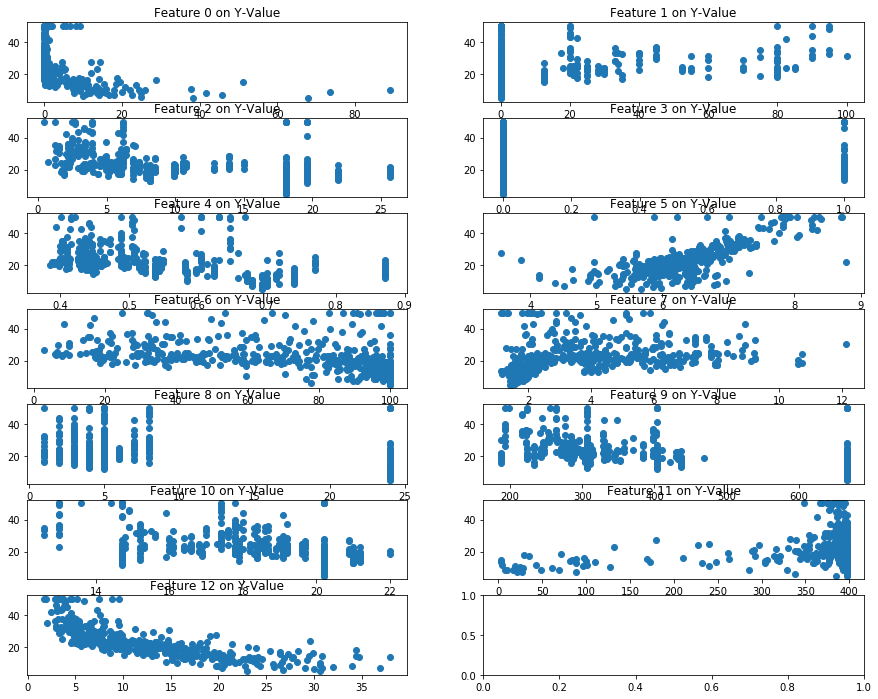

In [7]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15,12))

for i in range(13):
    r = i//2
    c = i%2
    axes[r][c].scatter(boston_df.iloc[:, i], boston_df.iloc[:, -1])
    axes[r][c].set_title("Feature %d on Y-Value"%(i))

## step forwards algorithm to select features

In [8]:
def select_features(features, dfs):
    df_train, df_valid = dfs
    # features is a SET, not a LIST
    cols = [c for c in df_train.columns if c in features]
    
    x_train = df_train[cols]
    x_valid = df_valid[cols]
    
    return x_train, x_valid

In [9]:
def get_score(features, dfs):
    x_train, x_valid = select_features(features, dfs)
    
    fitted_model = OLS(endog=y_train,exog=sm.add_constant(x_train),
                       hasconst=True).fit()

    f_valid = fitted_model.predict(sm.add_constant(x_valid))
    return r2_score(y_valid, f_valid)

In [10]:
def select_predictors(n, dfs):
    selected = set()
    total = set(list(range(n)))
    scores = np.zeros(n)
    features = []
    
    for i in range(n):
        i_scores = np.zeros(n-i)
        candidates = list(selected ^ total)

        for j, c in enumerate(candidates):
            selected.add(c)
            i_scores[j] = get_score(selected, dfs)
            selected.discard(c)
   
        best = np.argmax(i_scores)
        scores[i] = np.max(i_scores)
        selected.add(candidates[best])
        features.append(list(selected))
    
    return np.max(scores), features[np.argmax(scores)]

In [11]:
import warnings
warnings.filterwarnings('ignore')
best_score, best_features = select_predictors(13, (train_data, valid_data))
print(best_score, best_features)

0.7812446332610501 [5, 10, 7, 12, 9, 1, 8]


## Feature Transformations

### Try to apply log transformation on feature 12

In [12]:
def apply_log(df, col):
    df[col] = np.log(df[col])
    return df

In [25]:
x_train = train_data[best_features]
print(len(x_train), len(y_train))
x_valid = valid_data[best_features]

# actually selecting column with index=12
# NOT the 12th column
x_train = apply_log(x_train, 12)
x_valid = apply_log(x_valid, 12)

fitted_model = OLS(endog=y_train,exog=sm.add_constant(x_train),
                       hasconst=True).fit()
f_valid = fitted_model.predict(sm.add_constant(x_valid))

print(r2_score(y_valid, f_valid))

360 360
0.7849602867097921


### Scale feature 9 since it has large values compared to others

In [14]:
def scale(df, col, scaler=None):
    
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(df[col][:, None])
    
    df[col] = scaler.transform(df[col][:, None])
    return df, scaler

In [15]:
x_train, scaler = scale(x_train, 9)
x_valid, _ = scale(x_valid, 9, scaler)

fitted_model = OLS(endog=y_train,exog=x_train,
                       hasconst=True).fit()
f_valid = fitted_model.predict(x_valid)

print(r2_score(y_valid, f_valid))

0.7504209970453717


## Cross Validation

In [66]:
def feat_eng(train, valid, feats, isLog=True, isScale=False):
    # Selecting features
    x_train = train[feats]
    x_valid = valid[feats]
        
    # Y-Values
    y_train = train.iloc[:,-1]
    y_valid = valid.iloc[:,-1]
        
    # Log
    if isLog:
        x_train = apply_log(x_train, 12)
        x_valid = apply_log(x_valid, 12)
        
    # Standardize
    if isScale:
        x_train, scaler = scale(x_train, 9)
        x_valid, _ = scale(x_valid, 9, scaler)
        
    return (x_train, y_train, x_valid, y_valid)

In [67]:
def cross_validate(df, feats, k=10):
    split = 1/k
    scores = np.zeros((k,3))
    for i in range(k):
        train, valid = train_test_split(df.copy(), test_size=split, shuffle=True)
        #####################################################################################
        ## Logging & Scaling
        # Feature Engineering
        x_train, y_train, x_valid, y_valid = feat_eng(train, valid, feats, isScale=True)
        # Train and Validate
        fitted_model = OLS(endog=y_train,
                           exog=sm.add_constant(x_train),
                           hasconst=True).fit()
        f_valid = fitted_model.predict(sm.add_constant(x_valid))
        # Score
        scores[i, 0] = r2_score(y_valid, f_valid)
        
        #####################################################################################
        ## No Scaling
        # Feature Engineering
        x_train, y_train, x_valid, y_valid = feat_eng(train, valid, feats)
        # Train and Validate
        fitted_model = OLS(endog=y_train,
                           exog=sm.add_constant(x_train),
                           hasconst=True).fit()
        f_valid = fitted_model.predict(sm.add_constant(x_valid))
        # Score
        scores[i, 1] = r2_score(y_valid, f_valid)  
        
        #####################################################################################
        ## No Scaling & No Logging
        # Feature Engineering
        x_train, y_train, x_valid, y_valid = feat_eng(train, valid, feats, isLog=False)
        # Train and Validate
        fitted_model = OLS(endog=y_train,
                           exog=sm.add_constant(x_train),
                           hasconst=True).fit()
        f_valid = fitted_model.predict(sm.add_constant(x_valid))
        # Score
        scores[i, 2] = r2_score(y_valid, f_valid)
    return np.mean(scores, axis=0)
    
cross_validate(boston_df, best_features)

array([0.716037  , 0.716037  , 0.64411975])

### Seems like standardizing makes no difference for 9th feature

### Logging the 12th feature helps